In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.coordinates import Distance
from astropy import units as u
from astropy.coordinates import SkyCoord
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits

plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
z_50 = 0.0115
z_100 = 0.0235
z_200 = 0.047
z_500 = 0.12
lambda_50 = 6563.*(z_50+1.)
lambda_100 = 6563.*(z_100+1.)
lambda_200 = 6563.*(z_200+1.)
lambda_500 = 6563.*(z_500+1.)


In [3]:
def loadSDSS():
    z=[]
    with open('./data/Skyserver_SQL_1_xyz.csv','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split(',')
                z.append(float(tmp[1]))
    with open('./data/Skyserver_SQL_2_xyz.csv','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split(',')
                z.append(float(tmp[1]))
    z = np.array(z,'d')
    
    return z


In [4]:
def loadUVES():
    # UVES Sky background files (continuum and emission lines)
    filename1 = homedir+'/Dropbox/UVES_Sky_Background/UVES_sky_all/fluxed_sky_580U.fits'
    filename2 = homedir+'/Dropbox/UVES_Sky_Background/UVES_sky_all/fluxed_sky_860L.fits'
    hdulist1 = fits.open(filename1)
    hdulist2 = fits.open(filename2)
    flux1 = hdulist1[0].data
    flux2 = hdulist2[0].data
    
    CRPIX1 = hdulist1[0].header['CRPIX1']
    CRVAL1 = hdulist1[0].header['CRVAL1']
    CDELT1 = hdulist1[0].header['CDELT1']
    #print(CRPIX1,CRVAL1,CDELT1)
    hdulist1.close()
    begin = CRVAL1 - CRPIX1*CDELT1   
    end = begin + len(flux1)*CDELT1
    wavelength1 = np.arange(begin,end,CDELT1)
    #print(len(wavelength1),len(flux1))

    CRPIX1 = hdulist2[0].header['CRPIX1']
    CRVAL1 = hdulist2[0].header['CRVAL1']
    CDELT1 = hdulist2[0].header['CDELT1']
    #print(CRPIX1,CRVAL1,CDELT1)
    hdulist2.close()
    begin = CRVAL1 - CRPIX1*CDELT1   
    end = begin + len(flux2)*CDELT1
    wavelength2 = np.arange(begin,end,CDELT1)
    #print(len(wavelength2),len(flux2))
    
    return flux1,flux2,wavelength1,wavelength2


In [5]:
def loadUVESlinelists():
    # UVES identified line lists
    line_wavelength = []
    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_580U.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_860L.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    line_wavelength = np.array(line_wavelength,'d')
    
    return line_wavelength


In [6]:
def plotSDSShist(ax,start=6550.,end=7450.):
    filterwidth = 3. #nm
    z_filterwidth = filterwidth/660. # 1nm
    numbins = 0.2/z_filterwidth
    #plt.hist(z,bins=round(numbins))

    ### First try
    wavelength = 6563.*(1.+z)
    ax.hist(wavelength,bins=round(numbins))
    
    ax.set_xlim(start,end)
    ax.set_ylabel('# of SDSS galaxies')
    
    # locations off 50Mpc, 100Mpc, 200Mpc, 500Mpc away
    for wavelen,name in zip([lambda_50,lambda_100,lambda_200,lambda_500],['50 Mpc','100 Mpc','200 Mpc','500 Mpc']):
        ax.plot([wavelen,wavelen],[0.,35000.],'k--',linewidth=2)
        ax.text(wavelen-20.,25000,name,rotation='vertical')


In [7]:
def plotskybackground(ax,start=6550.,end=7450.):
    indices1 = (wavelength1>start) & (wavelength1<end)
    if len(wavelength1[indices1])>0:
        newstart = wavelength1[indices1][-1]
        print newstart
    else:
        newstart=start
        print newstart
    indices2 = (wavelength2>newstart) & (wavelength2<end)
    #ax.plot(wavelength1[indices1],flux1[indices1])
    #ax.plot(wavelength2[indices2],flux2[indices2])
    ax.plot(np.concatenate([wavelength1[indices1],wavelength2[indices2]]),
            np.concatenate([flux1[indices1],flux2[indices2]]))
    ax.set_ylim(0,1)
    ax.set_xlim(start,end)
    ax.set_ylabel('Flux (sky)')
    
    # identified lines
    for line in line_wavelength:
        ax.plot([line],[1.5],'ro')
    
    # locations off 50Mpc, 100Mpc, 200Mpc, 500Mpc away
    for wavelen,name in zip([lambda_50,lambda_100,lambda_200,lambda_500],['50 Mpc','100 Mpc','200 Mpc','500 Mpc']):
        ax.plot([wavelen,wavelen],[0.,3.],'k--',linewidth=2)
       # if (wavelen>lowlim) and (wavelen<(lowlim+300.)):
       #     plt.text(line,1.5,name,rotation=90)
        
    # pretend filter (3 nm wide)
    #ax.fill_between([lowlim+240.,lowlim+240.+30.], 0, 1.5,facecolor ='yellow',alpha=0.4)
    #ax.plot([lowlim+240.,lowlim+240.,lowlim+240.+30.,lowlim+240.+30.,lowlim+240.],[0,1.5,1.5,0,0],'g-',linewidth=2)

    ax.set_xlabel('wavelength (nm)')


In [8]:
machine = 'coho'
if machine=='chinook':
    homedir = 'Users/lokhorst'
elif machine=='coho':
    homedir = '/Users/deblokhorst'

In [9]:
z=loadSDSS()
flux1,flux2,wavelength1,wavelength2=loadUVES()
line_wavelength=loadUVESlinelists()

In [10]:
def plot1():
    f = plt.figure(figsize=(3.,3.))
    f, (ax1, ax2) = plt.subplots(2, figsize=(10.,5.))
    #ax1.set_title('UVES Sky Background')
    plotSDSShist(ax1,start=6550.,end=7000.)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plotskybackground(ax2,start=6550.,end=7000.)
    f.subplots_adjust(hspace=0.1)
    
def plot2():
    f = plt.figure(figsize=(3.,3.))
    f, (ax1, ax2) = plt.subplots(2, figsize=(10.,5.))
    #ax1.set_title('UVES Sky Background')
    plotSDSShist(ax1,start=7000.,end=7450.)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plotskybackground(ax2,start=7000.,end=7450.)
    f.subplots_adjust(hspace=0.1)
    
def plot3():
    f = plt.figure(figsize=(3.,10.))
    f, (ax1, ax2) = plt.subplots(2, figsize=(10.,5.))
    plotSDSShist(ax1,start=6550.,end=7450.)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plotskybackground(ax2,start=6550.,end=7450.)
    f.subplots_adjust(hspace=0.1)


//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 45277 but corresponding boolean dimension is 45278
  del sys.path[0]


6799.96298


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


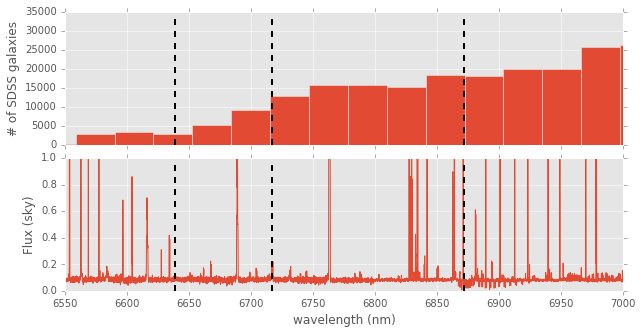

In [11]:
plot1()

7000.0


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 45277 but corresponding boolean dimension is 45278
  del sys.path[0]


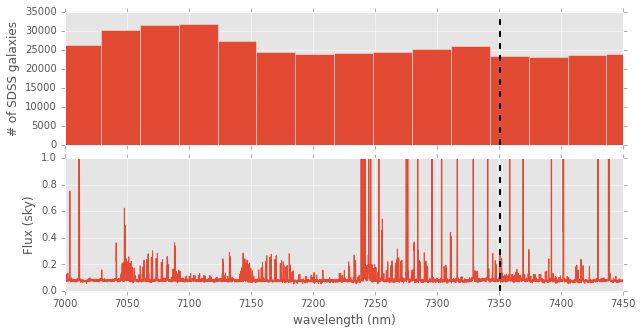

In [15]:
plot2()

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 45277 but corresponding boolean dimension is 45278
  del sys.path[0]


6799.96298


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


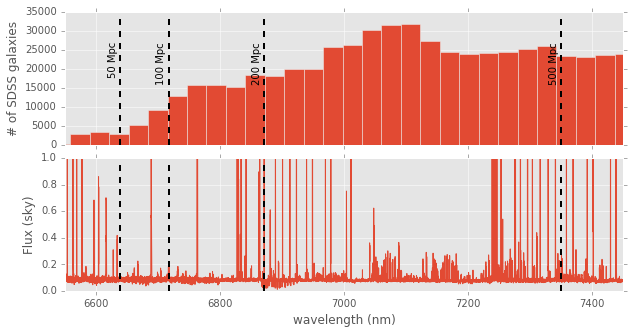

In [11]:
plot3()
plt.savefig('SDSS_and_skybackground.pdf')